## Initialization:
Fill the missing values in this text box and in the following code-cell.

**Academic Year:** 2024/2025

### Team Members (Alphabetical Order):
1. Fazlollahnezhad, Kamyar (s341418);
2. Shivaei, Shahrzad (s343616).

## Prepration:
First we import required libraries:



In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.csgraph import connected_components
import scipy.sparse.linalg as splinalg
from scipy.sparse.linalg import eigsh
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eig
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN , SpectralClustering, Birch
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


### Loading the datasets
First we load the circle dataset:

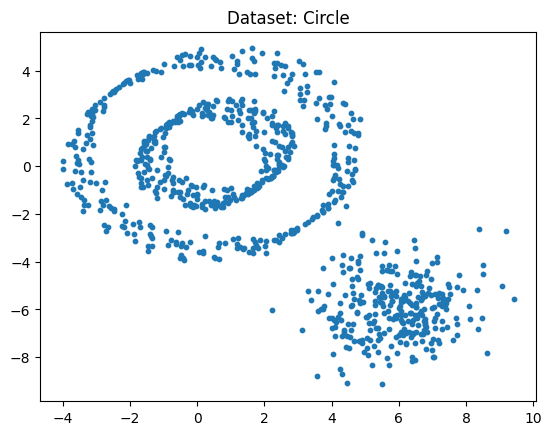

In [11]:
X = np.loadtxt("Circle.csv", delimiter=',')
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title("Dataset: Circle")
plt.show()


Then we want to see the structure of this dataset:

In [12]:
circle_df = pd.read_csv('Circle.csv', header=None)
circle_df.columns = ['x','y']
circle_df.head()

,x,y
0,2.7147,0.81472
1,2.8054,0.94572
2,2.0253,0.20682
3,2.8096,1.03310
4,2.5257,0.79188


First we load the spiral dataset:

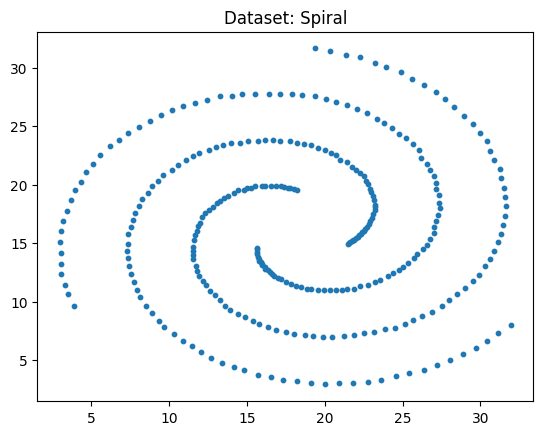

In [13]:
X = np.loadtxt("Spiral.csv", delimiter=',')
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title("Dataset: Spiral")
plt.show()


Again we want to see the structure of this dataset:

In [14]:
spiral_df = pd.read_csv('Spiral.csv', header=None)
spiral_df.columns = ['x', 'y', 'label']
spiral_df.head()

,x,y,label
0,31.95,7.95,3
1,31.15,7.30,3
2,30.45,6.65,3
3,29.70,6.00,3
4,28.90,5.55,3


# Task No.1
Here we want to implement task 1. In order to do so, first we need to define a function to compute similarity between each pair of the points. function 'compute_similarity_matrix' does this task. actually it takes a set of points and calculates distance between each pair of the dataset using the metric presented in the peoblem:  

$s_{i,j} = exp (-\frac{(||X_i − X_j||^2)}{2σ^2})$


In [15]:
def compute_similarity_matrix(X, sigma):
    N = X.shape[0]
    similarity_matrix = np.exp(-np.sum((X[:, np.newaxis] - X)**2, axis=2) / (2 * sigma**2))
    np.fill_diagonal(similarity_matrix, 0)
    return similarity_matrix

In [16]:
spiral_x = spiral_df[['x', 'y']].values
circle_x = circle_df[['x', 'y']].values
sigma = 1
Spiral_similarity_matrix = compute_similarity_matrix(spiral_x, sigma)
circle_similarity_matrix = compute_similarity_matrix(circle_x, sigma)
print('Spiral Shape: ',Spiral_similarity_matrix.shape)
print('Circle Shape: ',circle_similarity_matrix.shape)

Spiral Shape:  (312, 312)
Circle Shape:  (900, 900)


Using the Similarity matrix defined above, here we try to find k nearest neighbor of each point and construct a matrix, such that each row(and consequently each column) has k non-zero values shwoing which points are the corresponding points's close neighbours.  
Note thath the (spiral_knn_adj_matrix, circle_knn_adj_matrix) are adjacency matrix for each datasets.

In [17]:
def compute_knn_similarity_matrix(similarity_matrix, k, sigma):
    knn_similarity_matrix = np.zeros_like(similarity_matrix)
    for i in range(similarity_matrix.shape[0]):
        k_nearest_neighbors = np.argsort(similarity_matrix[i])[-k:]
        knn_similarity_matrix[i, k_nearest_neighbors] = similarity_matrix[i, k_nearest_neighbors]
        knn_similarity_matrix[k_nearest_neighbors, i] = similarity_matrix[k_nearest_neighbors, i]
    return knn_similarity_matrix


k = 10
spiral_knn_adj_matrix = compute_knn_similarity_matrix(Spiral_similarity_matrix, k, sigma)

circle_knn_adj_matrix = compute_knn_similarity_matrix(circle_similarity_matrix, k, sigma)

#check if the diagonal elements are zero
print('Spiral dataset: ', np.diag(spiral_knn_adj_matrix).sum())
print('Circle dataset: ', np.diag(circle_knn_adj_matrix).sum())

Spiral dataset:  0.0
Circle dataset:  0.0


# Task No2.
Here we construct degree and laplacian matrices, which are simple in definition however I describe them here breifly:  
* Degree Matrix: degree matrix of an undirected graph is a diagonal matrix which contains information about the degree of each vertex—that is, the number of edges attached to each vertex.
* Laplacian Matrix: Is defined as the differences of degree matrix and adjacency matrix. It is a fundamental concept in graph theory, used to study the structure and properties of graphs. It captures the relationship between nodes and edges in a graph and is widely used

In [18]:
def compute_degree_matrix(adjacency_matrix):
    adjacency_matrix = csr_matrix(adjacency_matrix)
    degree_vector = np.asarray(adjacency_matrix.sum(axis=1)).flatten()
    return csr_matrix(np.diag(degree_vector))

spiral_laplaican_matrix = compute_degree_matrix(spiral_knn_adj_matrix) - spiral_knn_adj_matrix
circle_laplaican_matrix = compute_degree_matrix(circle_knn_adj_matrix) - circle_knn_adj_matrix
print('Spiral dataset: \n', spiral_laplaican_matrix)
print("============================================================")
print('\nCircle dataset: \n', circle_laplaican_matrix)

Spiral dataset: 
 [[ 0.7400033  -0.58786967 -0.13945686 ...  0.          0.
   0.        ]
 [-0.58786967  1.38989147 -0.6336554  ...  0.          0.
   0.        ]
 [-0.13945686 -0.6336554   1.56387582 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  7.50068164 -0.96923323
  -0.94058806]
 [ 0.          0.          0.         ... -0.96923323  6.54768684
  -0.99501248]
 [ 0.          0.          0.         ... -0.94058806 -0.99501248
   6.10367257]]

Circle dataset: 
 [[ 9.56687889 -0.98738648  0.         ...  0.          0.
   0.        ]
 [-0.98738648 10.39869095  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         10.29397786 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  8.77786359  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         11.61410051
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   7.533866  ]]


# Task No3.
Here we try to compute the number of connected components of the similarity graph. In other words, we want derive how many classes is proper for classifying the points.  
Our way to reach this purpose is to find the factor of zero eigenvalues of the laplacian matrix for each dataset. Keep in mind that in the concept of similarity metric (points are not connected explicitly), by zero eigenvalue, we mean eigenvalues below a small threshold.  
Function 'compute_sorted_eigenvalues_eigenvectors()', calculates the first m eigenvectors and eigenvalues of the input matrix. by first, I mean first eigenvectors based on the sorting of the eigenvalues(eigenvectors corresponding to the smallest eigenvectors).  
Then, function 'compute_connected_components()' compares each eigenvalue with a relatevly small threshold and outputs number of the eigenvalues which are bigger than the threshold value.

In [19]:
def compute_sorted_eigenvalues_eigenvectors(laplacian_matrix, m = None):
    eigenvalues, eigenvectors = eigsh(laplacian_matrix, k=5, which='SM')
    sorted_indices = np.argsort(eigenvalues)
    if m is None:
        return eigenvalues[sorted_indices], eigenvectors[:, sorted_indices]
    return eigenvalues[sorted_indices][:m], eigenvectors[:, sorted_indices][:, :m]


def compute_connected_components(laplacian_matrix, threshold=1.0e-4, m=5):
    eigenvalues, _ = compute_sorted_eigenvalues_eigenvectors(laplacian_matrix, m)
    return sum(eigen_val < threshold for eigen_val in eigenvalues)


def plot_eigenvalues(sorted_eigenvalues, title, threshold=1.0e-3):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(sorted_eigenvalues) + 1), sorted_eigenvalues, 'b-')
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue')
    num_connected_components = sum(eigen_val < threshold for eigen_val in sorted_eigenvalues)
    plt.text(0.5, 0.5, f'Number of connected components: {num_connected_components}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='r')
    plt.axhline(y=threshold, color='r', linestyle='--')
    plt.title(title)
    plt.show()


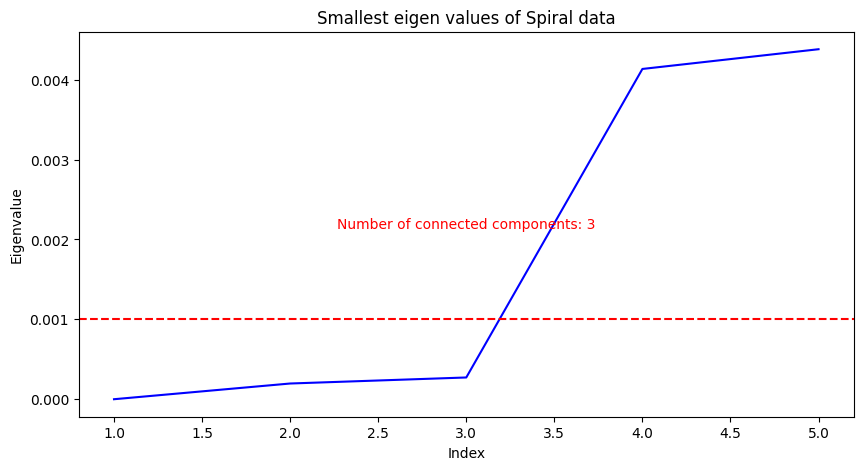

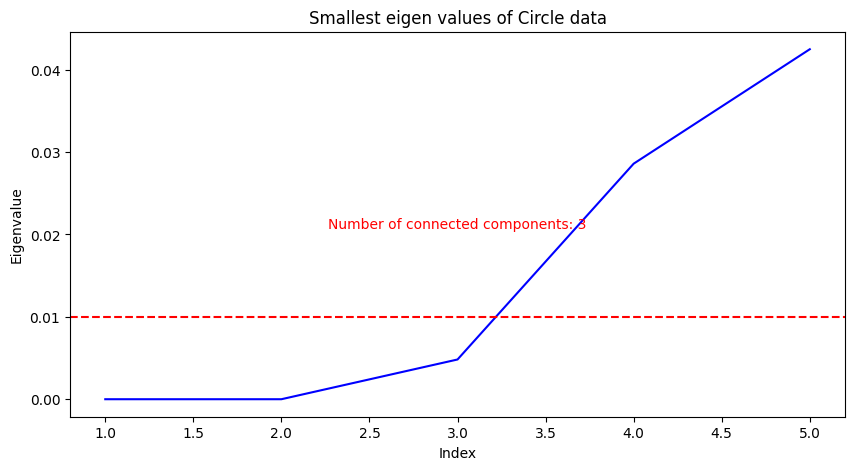

In [20]:
spiral_num_connected_components = compute_connected_components(spiral_laplaican_matrix)
circle_num_connected_components = compute_connected_components(circle_laplaican_matrix)

for matrix, title, th in [(spiral_laplaican_matrix, "Smallest eigen values of Spiral data", 1e-3),
                      (circle_laplaican_matrix, "Smallest eigen values of Circle data", 1e-2)]:
    eigenvalues, _ = compute_sorted_eigenvalues_eigenvectors(matrix)
    plot_eigenvalues(eigenvalues, title, threshold=th)


## Task No4.
As completely computed above, we assume the number of clusters is the same as the number of the connected components. Also the function to compute both eigen vectors and eigenvalues was defined in the previous section, therefore, here we just run that function:

In [21]:
sorted_eigen_val_circle, sorted_eigen_vec_circle = compute_sorted_eigenvalues_eigenvectors(circle_laplaican_matrix, 3)
sorted_eigen_val_spiral, sorted_eigen_vec_spiral = compute_sorted_eigenvalues_eigenvectors(spiral_laplaican_matrix, 3)

## Task No5.
In the code blocks of Task 3, we defined a function which computes both eigenvalues and eigenvectors of s mstrix. also we have to again note that the eigenvalues were sorted (and their corresponding eigenvectors), therefore, here we don't need to anything more. we just normalize the previous resluts.

In [22]:
spiral_u = sorted_eigen_vec_spiral / np.linalg.norm(sorted_eigen_vec_spiral, axis=1, keepdims=True)
circle_u = sorted_eigen_vec_circle / np.linalg.norm(sorted_eigen_vec_circle, axis=1, keepdims=True)

## Tasks No6 and 7.

Here we are utilizing the KMeans clustering algorithm from the sklearn.cluster module in Python to group data into clusters.

In [23]:
from sklearn.cluster import KMeans

def perform_clustering(original_data, u_normalized, n_clusters):
    # Perform k-means clustering and return the clustered data
    kmeans = KMeans(n_clusters=n_clusters).fit(u_normalized)
    clusters = [[] for _ in range(n_clusters)]
    for i, label in enumerate(kmeans.labels_):
        clusters[label].append(original_data[i])
    return clusters, kmeans.labels_

# Spiral and Circle clustering
spiral_clusters, spiral_clusters_labels = perform_clustering(spiral_x, spiral_u, n_clusters=3)
circle_clusters, circle_clusters_labels = perform_clustering(circle_x, circle_u, n_clusters=3)


## Task No8.

Here, we visualize different clusters using scatter plots by defining a reusable function. It uses Seaborn for styling and Matplotlib for plotting, presenting a clear visual representation of how the clusters are distributed in the dataset.

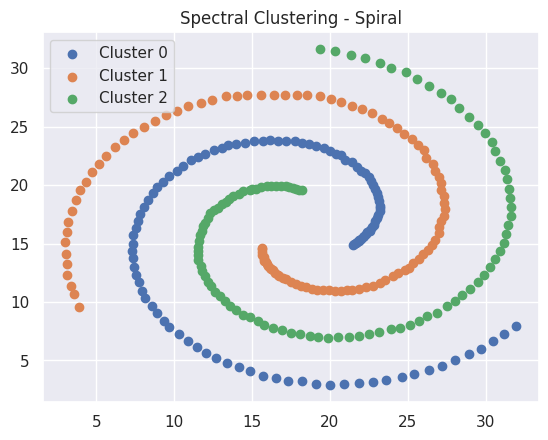

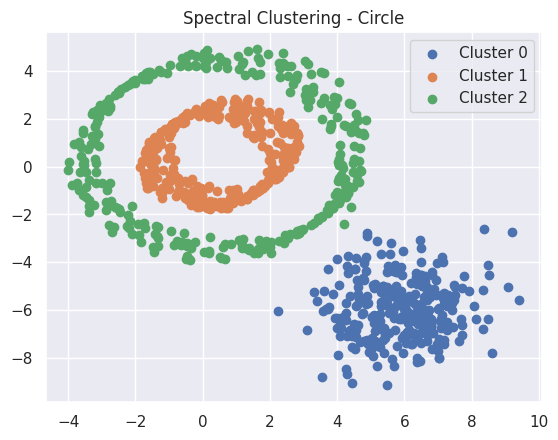

In [24]:
def plot_clusters(data, clusters, title):
    sns.set(style="darkgrid")
    fig, ax = plt.subplots()
    for i, cluster in enumerate(clusters):
        ax.scatter(np.array(cluster)[:, 0], np.array(cluster)[:, 1], label=f'Cluster {i}')
    ax.set_title(title)
    ax.legend()
    plt.show()

# Plot the clusters for both datasets
for clusters, title, data in [(spiral_clusters, 'Spectral Clustering - Spiral', spiral_x),
                              (circle_clusters, 'Spectral Clustering - Circle', circle_x)]:
    plot_clusters(data, clusters, title)


In [25]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def evaluate_clustering_performance(data, clusters_labels):
    # Compute and return the clustering performance metrics
    return (silhouette_score(data, clusters_labels, metric='euclidean'),
            calinski_harabasz_score(data, clusters_labels),
            davies_bouldin_score(data, clusters_labels))

# Evaluate clustering performance for Spiral and Circle datasets
spiral_metrics = evaluate_clustering_performance(spiral_x, spiral_clusters_labels)
circle_metrics = evaluate_clustering_performance(circle_x, circle_clusters_labels)

# Unpack the results
spiral_silhouette_coefficient, spiral_calinski_harabasz_score_coefficient, spiral_davies_bouldin_score_coefficient = spiral_metrics
circle_silhouette_coefficient, circle_calinski_harabasz_score_coefficient, circle_davies_bouldin_score_coefficient = circle_metrics


In [26]:
# Define the metrics for Spiral and Circle datasets
metrics = {
    'Silhouette Coefficient': [spiral_silhouette_coefficient, circle_silhouette_coefficient],
    'Calinski-Harabasz Score': [spiral_calinski_harabasz_score_coefficient, circle_calinski_harabasz_score_coefficient],
    'Davies-Bouldin Score': [spiral_davies_bouldin_score_coefficient, circle_davies_bouldin_score_coefficient]
}

# Create the results DataFrame
results = pd.DataFrame(metrics, index=['Spiral', 'Circle'])
results.index.name = 'Metrics'
results


,Silhouette Coefficient,Calinski-Harabasz Score,Davies-Bouldin Score
Metrics,,,
Spiral,0.001344,5.797852,5.882023
Circle,0.323268,902.993795,82.265848


## Task No9.

The first step is converting the dataset into a C-contiguous array for optimized memory access and compatibility with some clustering algorithms. Then we use four methods (K-Means, Agglomerative, Birch, Spectral) to cluster our circle and spiral dataset.

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


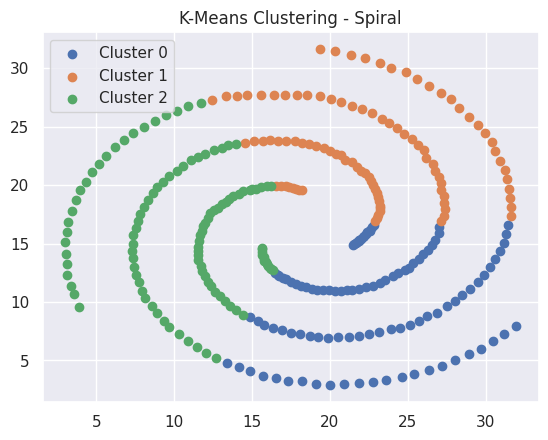

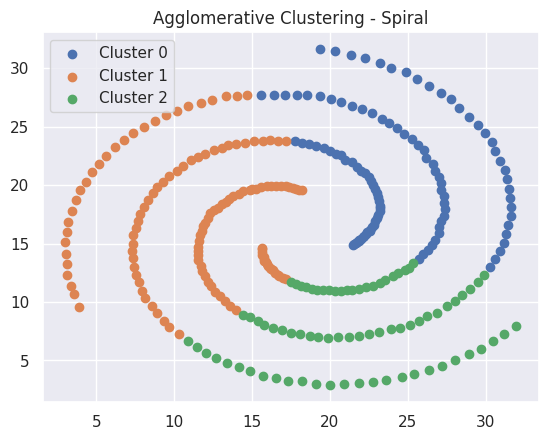

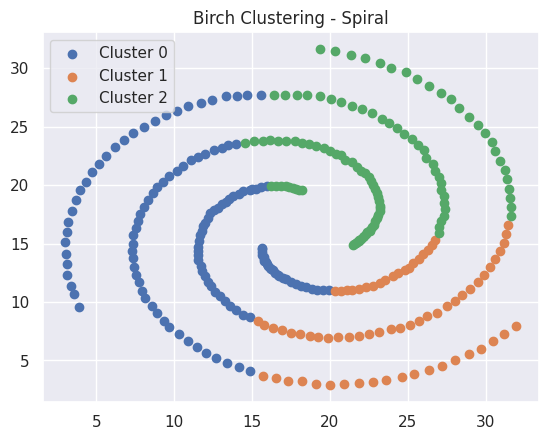

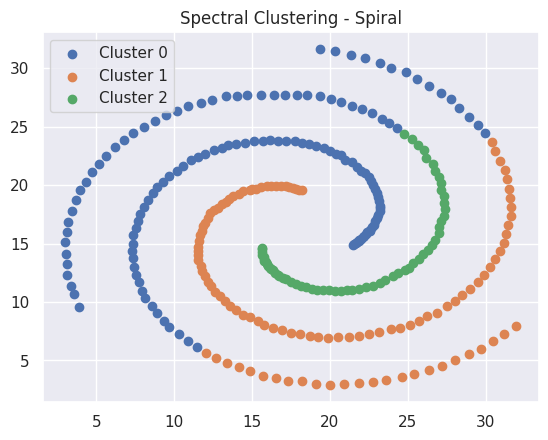

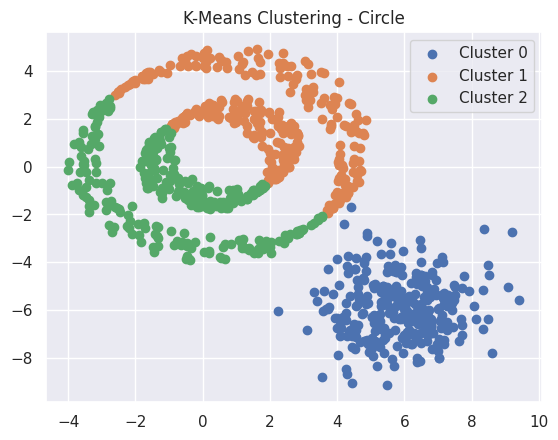

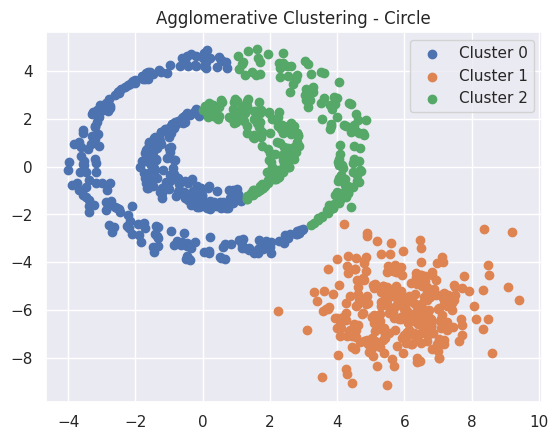

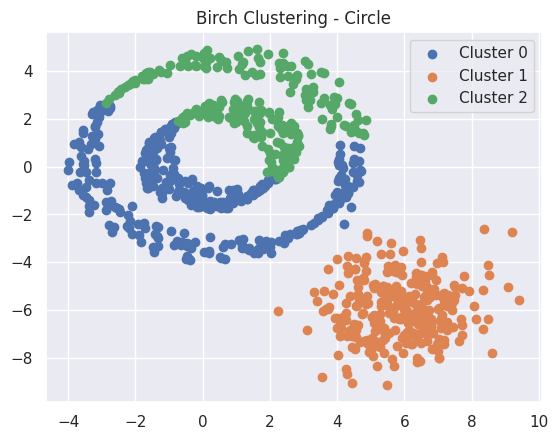

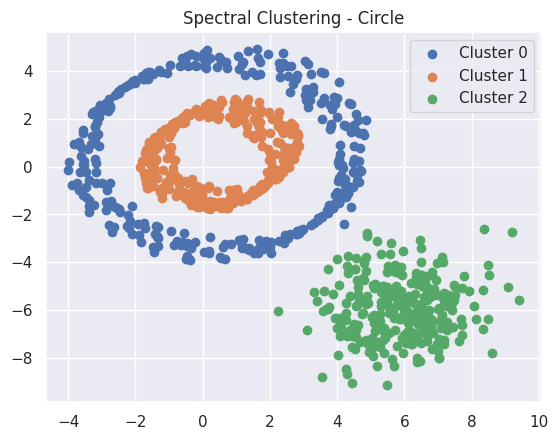

In [27]:
# Apply the clustering methods mentioned above to the datasets

def perform_clustering(data, n_clusters, clustering_method):

    # Ensure data is in C-contiguous order.
    data = np.ascontiguousarray(data)

    # Perform clustering.
    if clustering_method == AgglomerativeClustering:
        clustering = clustering_method(n_clusters=n_clusters, linkage='ward').fit(data)  # Removed affinity
    elif clustering_method == Birch:
        clustering = clustering_method(n_clusters=n_clusters).fit(data)
    elif clustering_method == SpectralClustering:
        clustering = clustering_method(n_clusters=n_clusters, affinity='nearest_neighbors').fit(data)
    else:
        clustering = clustering_method(n_clusters=n_clusters).fit(data)

    # Group the data based on the cluster labels.
    clusters = [[] for _ in range(n_clusters)]
    for i in range(data.shape[0]):

        # Append the data point to the corresponding cluster.
        clusters[clustering.labels_[i]].append(data[i])

    return clusters, clustering.labels_


def plot_clusters(data, clusters, title):
    sns.set(style="darkgrid")
    fig, ax = plt.subplots()

    for i in range(len(clusters)):
        cluster = np.array(clusters[i])
        # if array is one-dimensional, reshape it to two-dimensional
        if len(cluster.shape) == 1:
            cluster = cluster.reshape(-1, 1)

        ax.scatter(cluster[:, 0], cluster[:, 1], label='Cluster {}'.format(i))
    ax.set_title(title)
    ax.legend()
    plt.show()

# Spiral
spiral_kmeans_clusters, spiral_kmeans_clusters_labels = perform_clustering(spiral_x, n_clusters=3, clustering_method=KMeans)
spiral_agglomerative_clusters, spiral_agglomerative_clusters_labels = perform_clustering(spiral_x, n_clusters=3, clustering_method=AgglomerativeClustering)
spiral_birch_clusters, spiral_birch_clusters_labels = perform_clustering(spiral_x, n_clusters=3, clustering_method=Birch)
spiral_spec_clusters, spiral_spec_clusters_labels = perform_clustering(spiral_x, n_clusters=3, clustering_method=SpectralClustering)

# Circle
circle_kmeans_clusters, circle_kmeans_clusters_labels = perform_clustering(circle_x, n_clusters=3, clustering_method=KMeans)
circle_agglomerative_clusters, circle_agglomerative_clusters_labels = perform_clustering(circle_x, n_clusters=3, clustering_method=AgglomerativeClustering)
circle_birch_clusters, circle_birch_clusters_labels = perform_clustering(circle_x, n_clusters=3, clustering_method=Birch)
circle_spec_clusters, circle_spec_clusters_labels = perform_clustering(circle_x, n_clusters=3, clustering_method=SpectralClustering)

# Plot the clusters for Spiral dataset
plot_clusters(spiral_x, spiral_kmeans_clusters, 'K-Means Clustering - Spiral')
plot_clusters(spiral_x, spiral_agglomerative_clusters, 'Agglomerative Clustering - Spiral')
plot_clusters(spiral_x, spiral_birch_clusters, 'Birch Clustering - Spiral')
plot_clusters(spiral_x, spiral_spec_clusters, 'Spectral Clustering - Spiral')

# Plot the clusters for Circle dataset
plot_clusters(circle_x, circle_kmeans_clusters, 'K-Means Clustering - Circle')
plot_clusters(circle_x, circle_agglomerative_clusters, 'Agglomerative Clustering - Circle')
plot_clusters(circle_x, circle_birch_clusters, 'Birch Clustering - Circle')
plot_clusters(circle_x, circle_spec_clusters, 'Spectral Clustering - Circle')
